# 5. Grain phase function

## Overview

This tutorial showcases a more practical application and is a great introduction to write efficient integrator-like rendering code with the Mitsuba library.

In volumetric rendering, we talk about a *phase function* to discribe the angular distribution of light scattering when interacting with a particle in the medium. Have you ever wondered how a participating medium would look like if every particle had the shape of a bunny, or was made of frosty glass? ❄️🐰 For this you would need to know the phase function of such a medium, and this is what we are going to compute in this tutorial.

The following code is inspired from this great [paper](https://cs.dartmouth.edu/wjarosz/publications/meng15granular.html) where the authors manage to efficiently render granular materials, like sand, snow or sugar.

At a very high-level, here are the key stages of the algorithm we are going to use in this tutorial:

- Represent a single particle with a shape and a BSDF
- Generate rays coming from random directions around the particle object
- Compute bounces of the light path inside the particle until they escape
- Once escaped, record the out-going direction in the local frame of the original direction into a histogram

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Work with cartesian coordinate systems and coordinate frame object</li>
  <li>Use a sampler to generate random numbers</li>
  <li>Write a custom integrator-like script</li>
  <li>Use scatter reduction enoki routine to accumulate values into a histogram</li>
</ul>
    
</div>


### Step 1 - setup

Given the fact that phase functions can be wavelength-dependent, it only makes sense to perform our computations for a single wavelength at a time.  Luckily for us, as described in the [first tutorial](...), one key feature our retargetable renderer is the ability to choose the type used to represent colors in the simulation. Hence this is the perfect occasion to use the `*_mono` variant of our system, for which colors will be represented as a 1D array `Color1f`.

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../../build/python')

In [2]:
import enoki as ek 
import mitsuba
mitsuba.set_variant('llvm_mono')

### Step 2 - initialize the scene

To keep this tutorial simple, we are only going to compute the phase function of a dielectric sphere. Although it goes without saying that only minor changes would be necessary to allow the use of other shapes and materials in this script (e.g. a frosty glass bunny ❄️🐰).

On top of various mesh loaders (e.g. `ply`, `obj`, ...), Mitsuba supports several analytical shapes (e.g. `Sphere`, `Rectangle`, ...), that can be very handy when writing prototype applications. Also, note that even for a single object, ray-tracing operations in Mitsuba require the construction of a scene as it is responsible for the proper initialization of the ray-tracing backends (e.g. Embree / OptiX). 

Once again, we are going to use the `load_dict` routine to instanciate a scene containing a sphere as well as a dielectric BSDF.

In [3]:
from mitsuba.core.xml import load_dict

scene = load_dict({
    'type' : 'scene',
    'grain' : {
        'type' : 'sphere',
    }
})

bsdf = load_dict({
    'type' : 'dielectric',
    'int_ior' : 'water', # can also use float values
    'ext_ior' : 'air',   
})

2021-04-26 17:15:31 WARN main [Scene] No sensors found! Instantiating a perspective camera..

2021-04-26 17:15:31 WARN main [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgba).

2021-04-26 17:15:31 WARN main [Scene] No integrator found! Instantiating a path tracer..

2021-04-26 17:15:31 INFO main [Scene] Embree ready. (took 25ms)

Performing Monte-Carlo integration requires the ability to generate random numbers. Mitsuba comes along with a set of `Sampler` classes that can be used to perform such task. For simplicity in this application we are going to use the most basic sampler, `independent`, which we can instanciate with the `load_dict` routine.

In order to write vectorized code, we need to choose a *wavefront* size, corresponding to the amount of light path we are going to compute simultaneously. The `sampler` instance needs to be aware of the wavefront size so to produce random arrays of the right size. This can be done using the `mitsuba.render.Sampler.seed` method at the same time as choosing a seed for our random number generator (here `0`).

In [4]:
sampler = load_dict({'type' : 'independent'})
sampler.seed(0, wavefront_size = int(1e7))

### Step 3 - generate primary rays

In the following cell, we are going to generate our primary rays, coming from all directions towards the center of the scene. For this, we use the sampler instance to generate random ray directions and offsets for the ray origins. The Sampler class only implements methods for producing 1D/2D uniformly distributed points in the unit interval/square. Luckily for us, Mitsuba provides a whole set of warping techniques that map from the unit square to other domains such as spheres, hemispheres, etc. Here we leverage the `mitsuba.core.warp.square_to_uniform_sphere` routine to generate a set of random ray directions from the 2D unit points given by `sampler.next_2d()`.

We then construct a coordinate frame `mitsuba.core.Frame3f` around the sampled ray directions which we will use to convert between local and world coordinate spaces.

We sample ray origin positions by first computing 2D offsets in $[-1, 1]^2$ using the sampler instance. We can then easily compute 3D positions in local coordinates, where we offset the z-component by `-1` as the z-axis represent the forward ray direction. Using the coordinate frame object, we convert the ray origin positions from local to world coordinate space.

The `mitsuba.render.Scene` class exposes a `bbox` method which can be used to retrieve the bounding box of the entire scene. We then convert it a bounding sphere and use it to move the ray origin accordingly so to make sure our set of rays covers the entire scene domain.

Finally, we create primary rays of type `mitsuba.render.Ray3f`, setting the desired wavelength for our simulation.

In [5]:
from mitsuba.core.warp import square_to_uniform_sphere
from mitsuba.core import Float, UInt32, Color1f, Vector3f, Ray3f, Frame3f
from mitsuba.render import BSDFContext

# Sample ray directions
d = square_to_uniform_sphere(sampler.next_2d())

# Construct coordinate frame object
frame = Frame3f(d)

# Sample ray origins
xy_local = 2.0 * (sampler.next_2d() - 0.5)
local_o = Vector3f(xy_local.x, xy_local.y, -1.0)
world_o = frame.to_world(local_o)

# Move ray origin according to scene bounding sphere
bsphere = scene.bbox().bounding_sphere()
o = world_o * bsphere.radius + bsphere.center

# Construct rays
rays = Ray3f(o, d, time=0.0, wavelengths=Color1f(600.0))

### Step 4 - perform intra-grain transport

Let's now use those rays to construct light paths bouncing many times inside of the particle object.

For this, we perform a first ray intersection query with the scene using `mitsuba.render.Scene.ray_intersect` which will return a `mitsuba.render.SurfaceInteraction` object, containing surface interaction information. We use `is_valid` to find the rays that do interact with the object.

After initializing the `throughput` and `active` variables, we perform a loop to compute the different bounces of the light paths. At every iteration of the loop. we compute the following:

- Sample new directions from the BSDF using the sampler instance and the current surface interaction
- Update the throughput and rays for the next bounce using `spawn_ray`
- Trace the new set of rays to find the next intersection with the object
- Evaluate the kernels to make sure the JIT compiler doesn't accumulate instructions of all loop iterations

In [6]:
# Find first ray intersection with the object
si = scene.ray_intersect(rays)
valid = si.is_valid()

# Loop variables
throughput = Color1f(1.0)
active = valid

max_bounces = 10
for bounce in range(max_bounces):    
    # Sample new direction  
    ctx = BSDFContext() 
    bs, bsdf_val = bsdf.sample(ctx, si, sampler.next_1d(), sampler.next_2d(), active)
    
    # Update throughput and rays for next bounce 
    throughput[active] = bsdf_val * throughput
    rays[active] = si.spawn_ray(si.to_world(bs.wo))
    
    # Find next intersection
    si = scene.ray_intersect(rays, active)
    active = active & si.is_valid()    
    
    # Evaluate kernels
    ek.eval(si, rays, throughput, active)

### Step 5 - calculate the histogram

We are only interested in the light path that have escaped the object, hence we first need to update the `valid` mask array.

The escaping directions are given by the final ray direction, which we convert to local coordinates using the previously build `frame` object. It is then straighforward to compute the `theta` angle in spherical coordinates and the corresponding bin index in the histrogram.

Here it is important to account for the distortion introduces in the projection to spherical coordinates, hence we divide the throughput variable with the projection jacobian.

The histogram array is initialized using `ek.zero` and we accumulate the computed values into their corresponding bins using the `ek.scatter_reduce(ek.ReduceOp.Add, ...)` routine.

In [7]:
# Only account for rays that have escaped
valid = valid & ~active

# Resolution of the histogram
histogram_size = 512

# Convert escaping directions into histogram bin indices
cos_theta = Frame3f.cos_theta(frame.to_local(rays.d))
theta = ek.acos(cos_theta)
theta_idx = UInt32(theta / ek.Pi * histogram_size)

# Account for projection jacobian
throughput *= 1.0 / ek.sqrt(1 - cos_theta**2)

# Accumulate values into the histogram
histogram = ek.zero(Float, histogram_size)
ek.scatter_reduce(ek.ReduceOp.Add, histogram, throughput, theta_idx, valid)

# Execute the kernel by evaluating the histogram
ek.eval(histogram)

### Step 6 - plot the histogram

Let's now take a look at the resulting angular distribution! For this we plot it in log scale on a regular plot as well as a polar plot.

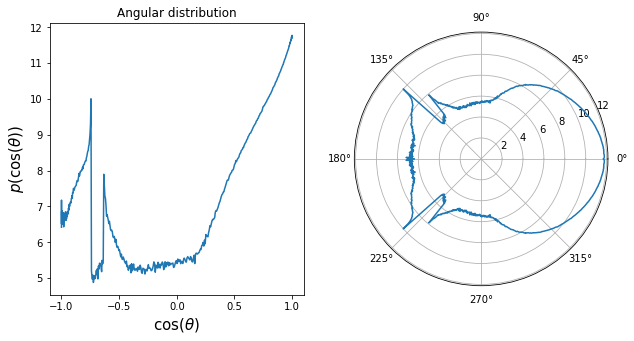

In [8]:
import numpy as np 
from matplotlib import pyplot as plt

x = ek.linspace(Float, 0, ek.Pi, len(histogram), endpoint=True)
histogram_log = ek.log(histogram)

fig = plt.figure(figsize = (10, 5))

ax = fig.add_subplot(121, title='Angular distribution') 
ax.plot(ek.cos(x), histogram_log, color='C0')
ax.set_xlabel(r'$\cos(\theta)$', size=15)
ax.set_ylabel(r'$p(\cos(\theta))$', size=15)

ax = fig.add_subplot(122, polar=True, title='polar plot') 
ax.plot( x, histogram_log, color='C0')
ax.plot(-x, histogram_log, color='C0', label='test');

### *Reference API*

- [<code>mitsuba.core.xml.load_dict</code>](...)
- [<code>mitsuba.core.warp.square_to_uniform_sphere</code>](...)
- [<code>mitsuba.core.Ray3f</code>](...)